# League of Legends Match Outcome Prediction with XGBoost

This notebook performs exploratory data analysis (EDA) and builds an XGBoost classifier to predict match outcomes in League of Legends. We'll analyze feature correlations, identify data leakage, and iteratively improve our model.

---

## 1. Import Libraries


In [444]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from scipy import stats


## 2. Load Datasets

We load two datasets:
- **lol_data_engineered.csv** - Player-level engineered features
- **team_stats.csv** - Team-level aggregated statistics

Region is one-hot encoded for both datasets.


In [445]:
lol_data_engineered = pd.read_csv("./data/lol_data_engineered.csv", delimiter=',', header="infer")
# Encode region as categorical
lol_data_engineered = pd.get_dummies(lol_data_engineered, columns=['region'], prefix='region')
print(lol_data_engineered.shape[0])

300000


### 2.1 Train-Test Split (lol_data_engineered)

Split the data 70-30 for training and testing.


In [446]:
train_data_lde, test_data_lde = train_test_split( lol_data_engineered, test_size=0.33, random_state=42)


### 2.2 Load Team Stats Dataset


In [447]:
team_stats = pd.read_csv("./data/team_stats.csv",delimiter=',', header="infer")
# Encode region as categorical
team_stats = pd.get_dummies(team_stats, columns=['region'], prefix='region')
team_stats.head()


,matchId,win,match_length,team_kills,team_deaths,team_assists,team_gold_at_15,team_cs_at_15,team_first_tower,team_first_dragon,...,total_damage_team,total_cs_team,dragon_kills_total,baron_kills_total,tower_kills_total,inhibitor_kills_total,team_gold_adv_at_15,region_EUN1,region_EUW1,region_NA1
0,EUN1_3539024926,0,1108,9,24,12,22859,381,0,0,...,36756,446,0,0,0,0,-8598,True,False,False
1,EUN1_3539024926,1,1108,24,9,39,31457,453,1,1,...,52970,550,2,0,7,1,8598,True,False,False
2,EUN1_3539783684,0,2006,35,43,63,26990,343,0,1,...,115582,671,3,0,2,0,395,True,False,False
3,EUN1_3539783684,1,2006,42,35,59,26595,457,1,0,...,142166,896,1,1,11,2,-395,True,False,False
4,EUN1_3539808405,0,2442,31,36,49,23313,463,0,1,...,171732,1074,2,1,3,0,-6750,True,False,False


### 2.3 Train-Test Split (team_stats)


In [448]:
train_data_ts, test_data_ts = train_test_split( team_stats, test_size=0.3, random_state=42)


## 3. Define Feature Columns

### 3.1 Features for lol_data_engineered (lde)

Separate features into:
- **Continuous** - Numerical values (kills, gold, etc.)
- **Categorical** - Binary/encoded features (region, first objectives)


In [449]:
continuous_columns_for_training_lde = [
    'kills', 'deaths', 'assists', 'total_gold', 'total_damage', 'total_cs',
    'gold at 15', 'cs at 15', 'match_length',
    'KDA', 'GPM', 'DPM', 'CSPM', 'KP', 'Gold_Share', 'Damage_Share', 'CS_Share',
    'Gold_at_15_PM', 'CS_at_15_PM',
    'dragon kills', 'baron kills', 'tower kills', 'inhib kills'
]

# Update category columns to include the new one-hot encoded columns
category_columns_for_training_lde = [col for col in lol_data_engineered.columns if col.startswith('region_')] + \
                                    ['team_first_tower', 'team_first_dragon', 'team_first_baron', 'team_first_inhibitor']


columns_for_training_lde = continuous_columns_for_training_lde + category_columns_for_training_lde
len(columns_for_training_lde)

30

### 3.2 Features for team_stats (ts)


In [450]:
continuous_columns_for_training_ts = [
    'match_length', 'team_kills', 'team_deaths', 'team_assists',
    'team_gold_at_15', 'team_cs_at_15', 'total_gold_team',
    'total_damage_team', 'total_cs_team', 'dragon_kills_total',
    'baron_kills_total', 'tower_kills_total', 'inhibitor_kills_total',
    'team_gold_adv_at_15'
]

# Update category columns
category_columns_for_training_ts = [col for col in team_stats.columns if col.startswith('region_')] + \
                                   ['team_first_tower', 'team_first_dragon', 'team_first_baron', 'team_first_inhibitor']

columns_for_training_ts = continuous_columns_for_training_ts + category_columns_for_training_ts

len(columns_for_training_ts)

21

## 4. Select Active Dataset

Toggle between `'lde'` (lol_data_engineered) and `'ts'` (team_stats) for analysis.


In [451]:
dataset = 'lde'
if dataset == 'ts':
    continuous_columns_for_training = continuous_columns_for_training_ts
    category_columns_for_training = category_columns_for_training_ts
    columns_for_training = columns_for_training_ts
    train_data = train_data_ts
    test_data = test_data_ts
    data_for_corr = team_stats.copy()
else:
    continuous_columns_for_training = continuous_columns_for_training_lde
    category_columns_for_training = category_columns_for_training_lde
    columns_for_training = columns_for_training_lde
    train_data = train_data_lde
    test_data = test_data_lde
    data_for_corr = lol_data_engineered.copy()


## 5. Correlation Analysis

### 5.1 Correlation Heatmap

Visualize relationships between all continuous features and the target variable `win`.


Using 24 continuous columns for correlation analysis


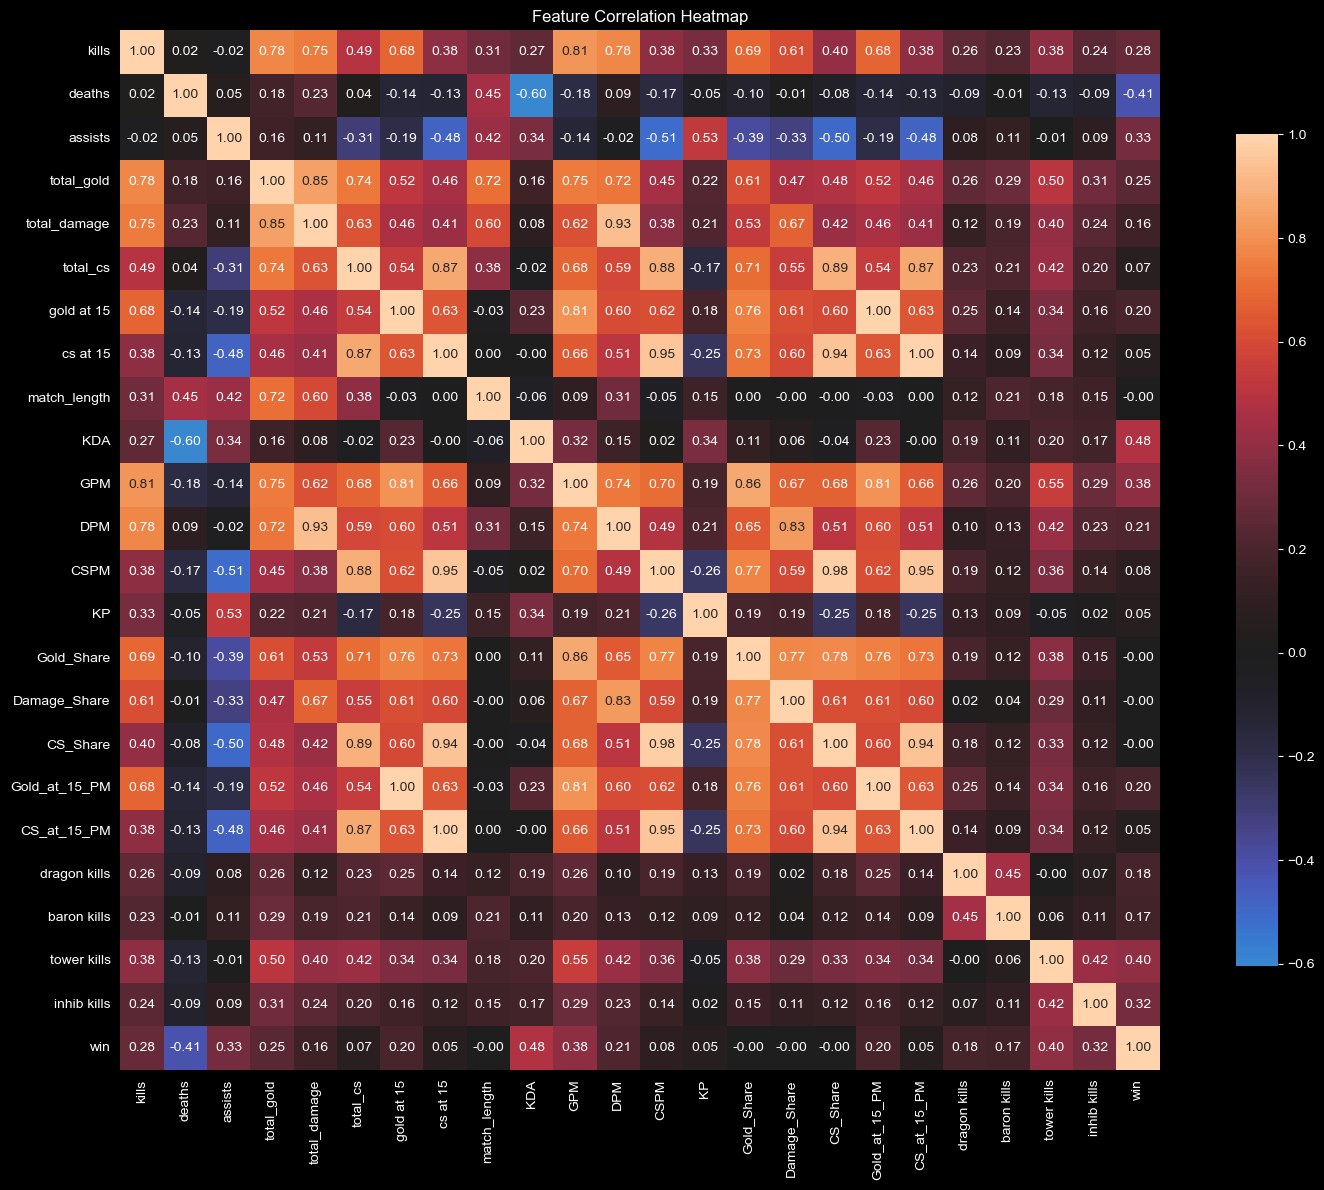

In [452]:
# Filter to only columns that actually exist in the dataframe
continuous_cols = [col for col in continuous_columns_for_training if col in data_for_corr.columns]
continuous_cols.append("win")
print(f"Using {len(continuous_cols)} continuous columns for correlation analysis")
# Full correlation heatmap for continuous features
plt.figure(figsize=(16, 12))
corr_matrix = data_for_corr[continuous_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f',
            center=0, square=True, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()
continuous_cols = [col for col in continuous_cols if col != 'win']

### 5.2 Feature Correlation with Win

Rank features by their Pearson correlation with the `win` column.


In [453]:
# Correlation matrix for continuous features with win
correlation_with_win_cont = data_for_corr[continuous_cols + ['win']].corr()['win'].drop('win').sort_values(ascending=False)
print("====| CORRELATION WITH WIN |====\n")
print(correlation_with_win_cont)


====| CORRELATION WITH WIN |====

KDA              4.846613e-01
tower kills      3.968751e-01
GPM              3.812936e-01
assists          3.281492e-01
inhib kills      3.225535e-01
kills            2.818938e-01
total_gold       2.466083e-01
DPM              2.133732e-01
gold at 15       1.967815e-01
Gold_at_15_PM    1.967815e-01
dragon kills     1.833882e-01
baron kills      1.703302e-01
total_damage     1.598112e-01
CSPM             8.227513e-02
total_cs         6.693370e-02
KP               5.491738e-02
cs at 15         5.374306e-02
CS_at_15_PM      5.374306e-02
Gold_Share      -9.700896e-19
Damage_Share    -1.238970e-18
CS_Share        -1.866054e-18
match_length    -1.820758e-17
deaths          -4.104214e-01
Name: win, dtype: float64


### 5.3 Correlation Bar Chart

Visualize the correlation coefficients. Green = positive, Red = negative correlation.


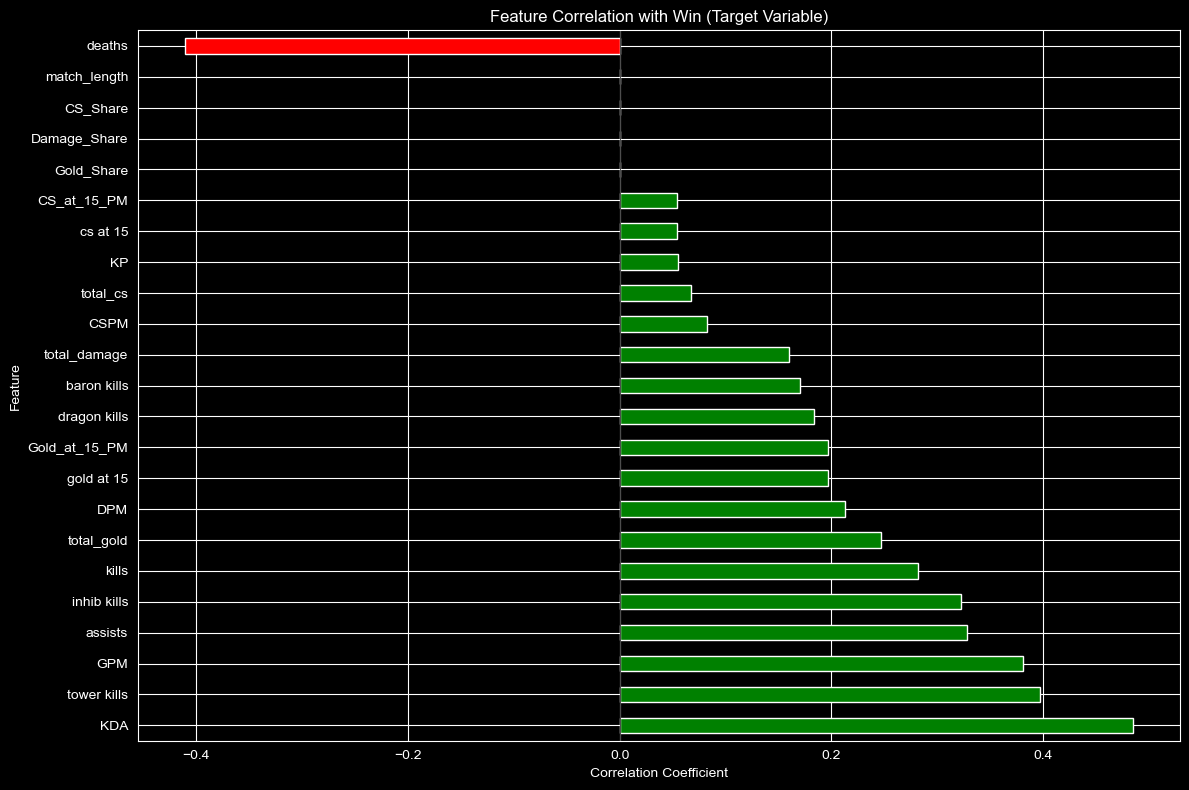

In [454]:
# Visualize correlation with win as a bar plot
plt.figure(figsize=(12, 8))
colors = ['green' if x > 0 else 'red' for x in correlation_with_win_cont.values]
correlation_with_win_cont.plot(kind='barh', color=colors)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.title('Feature Correlation with Win (Target Variable)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()


## 6. Categorical Feature Correlation

### Tetrachoric Correlation Formula

$$r = \cos\left(\frac{\pi}{1 + \sqrt{\frac{ad}{bc}}}\right)$$

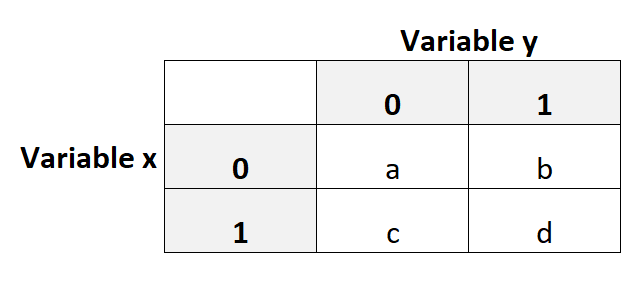

Tetrachoric correlation is used to calculate the correlation between **binary categorical variables**.

The value ranges from **-1 to 1**:
- **-1** = Strong negative correlation
- **0** = No correlation
- **1** = Strong positive correlation


In [455]:
def tetrachoric_correlation(x, y):
    """Calculate tetrachoric correlation for two binary variables."""
    contingency = pd.crosstab(x, y)
    if contingency.shape != (2, 2):
        return np.nan
    a, b = contingency.iloc[0, 0], contingency.iloc[0, 1]
    c, d = contingency.iloc[1, 0], contingency.iloc[1, 1]

    # Avoid division by zero
    if a * d == 0 or b * c == 0:
        return np.nan

    odds_ratio = (a * d) / (b * c)
    # Approximate tetrachoric using cosine approximation
    r = np.cos(np.pi / (1 + np.sqrt(odds_ratio)))
    return r


### 6.1 Calculate Tetrachoric Correlation

Compute correlation between each categorical feature and `win`.


In [456]:
categorical_cols = [col for col in category_columns_for_training if col in data_for_corr.columns]
print(f"Using {len(categorical_cols)} categorical columns for correlation analysis")

# Tetrachoric correlation for categorical features with win
tetrachoric_scores = {}
for col in categorical_cols:
    tetrachoric_scores[col] = tetrachoric_correlation(data_for_corr[col], data_for_corr['win'])

correlation_with_win_cat = pd.Series(tetrachoric_scores).sort_values(ascending=False)
print("====| TETRACHORIC CORRELATION WITH WIN |====\n")
print(correlation_with_win_cat)


Using 7 categorical columns for correlation analysis
====| TETRACHORIC CORRELATION WITH WIN |====

team_first_inhibitor    9.210913e-01
team_first_baron        7.047421e-01
team_first_tower        5.875318e-01
team_first_dragon       3.411508e-01
region_EUN1             6.123234e-17
region_EUW1             6.123234e-17
region_NA1              6.123234e-17
dtype: float64


### 6.2 Categorical Correlation Visualization


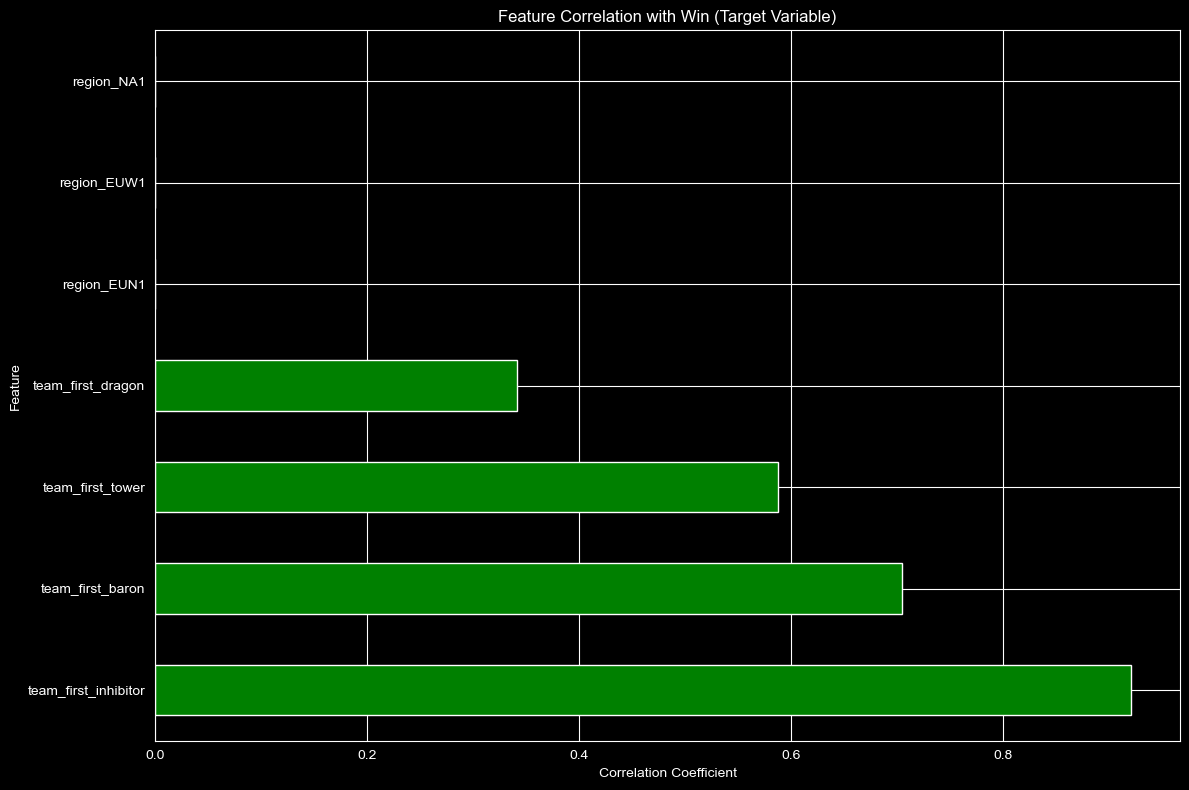

In [457]:
# Visualize correlation with win as a bar plot
plt.figure(figsize=(12, 8))
colors = ['green' if x > 0 else 'red' for x in correlation_with_win_cat.values]
correlation_with_win_cat.plot(kind='barh', color=colors)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.title('Feature Correlation with Win (Target Variable)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()


## 7. Model Training Functions

### 7.1 XGBoost Training Function

Trains an XGBoost classifier and displays:
- Feature importance ranking
- Confusion matrix
- Classification report


In [458]:
def train_xgboost(X_train, y_train, X_val, y_val):
    model = XGBClassifier()
    model.fit(X_train, y_train)

    feature_importance = model.feature_importances_
    feature_importance = pd.Series(feature_importance, index=columns_for_training).sort_values(ascending=False)
    print("====| FEATURE IMPORTANCES |====\n")
    print(feature_importance)

    predict = model.predict(X_val)

    # plot confusion matrix
    cm = confusion_matrix(y_val, predict, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    print("\n====| CONFUSION MATRIX |====")
    disp.plot()
    plt.show()

    # show classification report
    print("\n====| CLASSIFICATION REPORT |====\n")
    print(classification_report(y_val, predict))

    return model, predict


### 7.2 Metrics Computation Function

Calculates accuracy, precision, recall, and F1 score.


In [459]:
def compute_result(y, predictions):
    acc = accuracy_score(y, predictions)
    prec = precision_score(y, predictions)
    rec = recall_score(y, predictions)
    f1 = f1_score(y, predictions)

    result = pd.DataFrame({'Model': ['XGBoost']})

    result['accuracy'] = acc
    result['precision'] = prec
    result['recall'] = rec
    result['f1'] = f1

    return result


### 7.3 Feature Importance Plot Function


In [460]:
def plot_features(model, X_val):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
    plt.title('Feature Importance')


## 8. Baseline Model (All Features)

### 8.1 Prepare Training Data


In [461]:
X_train = train_data[columns_for_training]
y_train = train_data['win']
X_test = test_data[columns_for_training]
y_test = test_data['win']


### 8.2 Train Baseline Model

Train XGBoost with all 26 features.


====| FEATURE IMPORTANCES |====

team_first_inhibitor    0.720040
KDA                     0.057488
inhib kills             0.035218
team_first_tower        0.030758
team_first_baron        0.029714
match_length            0.026514
tower kills             0.013534
team_first_dragon       0.011616
GPM                     0.010826
Gold_Share              0.009944
KP                      0.009842
dragon kills            0.006025
assists                 0.005233
CS_Share                0.003555
baron kills             0.003230
CSPM                    0.003141
region_EUW1             0.002776
deaths                  0.002728
gold at 15              0.002695
region_NA1              0.002674
total_gold              0.002142
kills                   0.001865
total_cs                0.001608
DPM                     0.001578
cs at 15                0.001438
total_damage            0.001393
Damage_Share            0.001257
region_EUN1             0.001168
CS_at_15_PM             0.000000
Gold_at_15

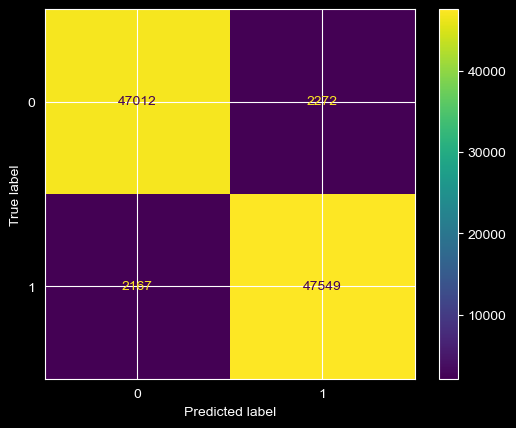


====| CLASSIFICATION REPORT |====

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     49284
           1       0.95      0.96      0.96     49716

    accuracy                           0.96     99000
   macro avg       0.96      0.96      0.96     99000
weighted avg       0.96      0.96      0.96     99000



In [462]:
# all feature model
model_21, prediction_21 = train_xgboost(X_train, y_train, X_test, y_test)


### 8.3 Feature Importance Visualization


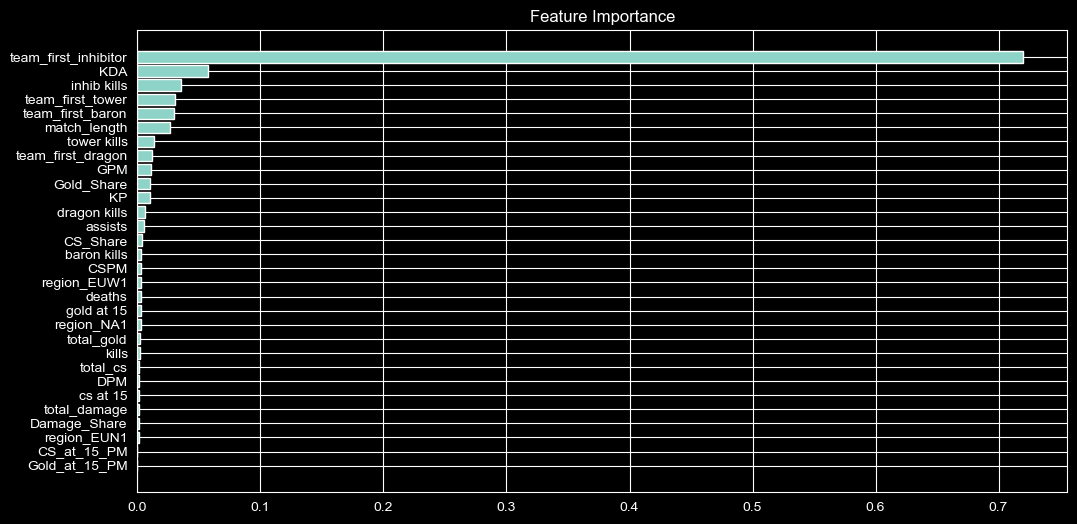

In [463]:
plot_features(model_21, X_test)


### 8.4 Baseline Model Results


In [464]:
result = compute_result(y_test, prediction_21)
result


,Model,accuracy,precision,recall,f1
0,XGBoost,0.955162,0.954397,0.956412,0.955404


## 9. Data Leakage Analysis

As it can be seen from the results of the base XGBoost classifier model, the results are **too accurate**, indicating that there are problems with the dataset.

Additionally, the previous correlations made with the `win` column indicate that there are features heavily tied to the win label. This indicates that the dataset causes **data leakage**.

### Why Leakage Happens (Game Mechanics):

| Feature | Reason for Leakage |
|---------|-------------------|
| `team_first_inhibitor` | First inhibitor is taken in late game; team that gets it usually wins |
| `total_gold`, `total_damage`, `total_cs` | End-game cumulative stats that directly reflect match outcome |
| `Gold_Share`, `Damage_Share`, `CS_Share` | Derived from the above features |
| `kills`, `deaths`, `assists` | Encompassed under KDA: `KDA = (Kills + Assists) / max(1, Deaths)` |


## 10. Low-Value Features

We also identified features with **low predictive value** from both correlation analysis and feature importance:

- `region_EUN1`, `region_EUW1`, `region_NA1` — Near-zero correlation with win
- `Gold_at_15_PM`, `CS_at_15_PM` — Low feature importance


## 11. Refined Model (Features Removed)

### 11.1 Remove Leaky and Low-Value Features


In [465]:
features_to_remove = [
    'region_EUN1', 'region_EUW1', 'region_NA1',
    'Gold_at_15_PM', 'CS_at_15_PM',
    'inhib kills', 'kills', 'deaths', 'assists', 'KDA', 'total_gold', 'total_damage', 'total_cs', 'Gold_Share', 'Damage_Share', 'CS_Share',
    'team_first_inhibitor',
    'team_first_baron',
]

columns_for_training_filtered = [col for col in columns_for_training if col not in features_to_remove]
columns_for_training = columns_for_training_filtered
print(columns_for_training)
X_train = train_data[columns_for_training]
y_train = train_data['win']
X_test = test_data[columns_for_training]
y_test = test_data['win']


['gold at 15', 'cs at 15', 'match_length', 'GPM', 'DPM', 'CSPM', 'KP', 'dragon kills', 'baron kills', 'tower kills', 'team_first_tower', 'team_first_dragon']


### 11.2 Train Refined Model

Train XGBoost with filtered features (11 remaining).


====| FEATURE IMPORTANCES |====

team_first_tower     0.445960
tower kills          0.177805
baron kills          0.117375
team_first_dragon    0.068653
GPM                  0.051267
dragon kills         0.039169
match_length         0.028238
CSPM                 0.023912
gold at 15           0.021415
KP                   0.010171
DPM                  0.009199
cs at 15             0.006835
dtype: float32

====| CONFUSION MATRIX |====


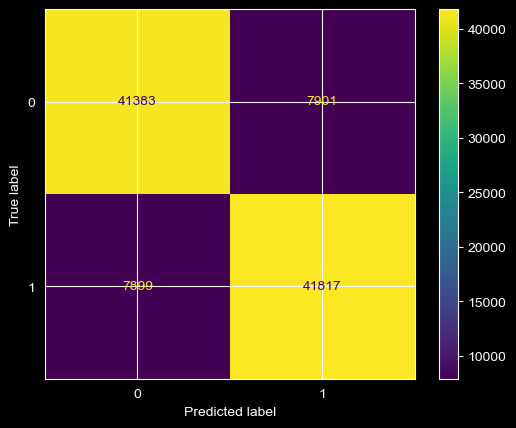


====| CLASSIFICATION REPORT |====

              precision    recall  f1-score   support

           0       0.84      0.84      0.84     49284
           1       0.84      0.84      0.84     49716

    accuracy                           0.84     99000
   macro avg       0.84      0.84      0.84     99000
weighted avg       0.84      0.84      0.84     99000



In [466]:
model_11, prediction_11 = train_xgboost(X_train, y_train, X_test, y_test)


### 11.3 Refined Feature Importance


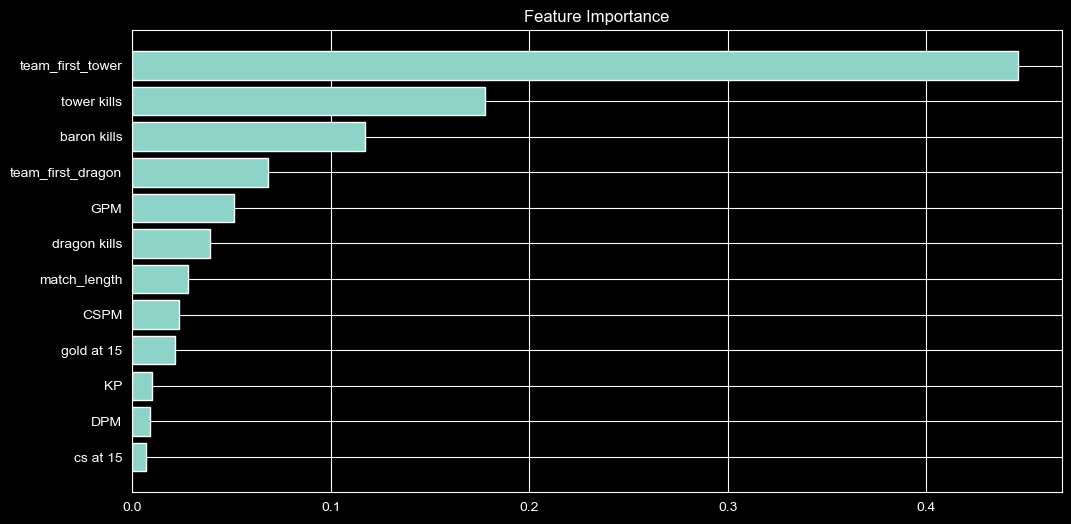

In [467]:
plot_features(model_11, X_test)


### 11.4 Refined Model Results


In [468]:
result = compute_result(y_test, prediction_11)
result


,Model,accuracy,precision,recall,f1
0,XGBoost,0.840404,0.841084,0.841118,0.841101
